## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 10900469.21it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175967.73it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3141175.64it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23368265.14it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for X_batch, y_batch in train_loader:
    break
print(X_batch.shape)
print(y_batch.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
import time

def train_model(model, train_loader, val_loader, loss_func, opt, n_epochs):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []

        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            label_pred = y_pred.argmax(dim=1)
            label_target = y_batch
            ep_train_accuracy.append((label_pred == label_target).float().mean().cpu())

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            #loss = loss_func(y_pred, label_target) # for NLLLoss
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                label_pred = y_pred.argmax(dim=1)
                label_target = y_batch
                #ep_val_loss.append(loss_func(y_pred, label_target).item())  # for NLLLoss
                ep_val_loss.append(loss_func(y_pred, y_batch).item())
                ep_val_accuracy.append((label_pred == label_target).float().mean().detach().cpu().numpy())


        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_accuracy.append(np.mean(ep_val_accuracy))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1}/{n_epochs}, took {time.time() - start_time:.3f} s; ', end='')
        print(f'train loss: {train_loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}; ', end='')
        print(f'train acc: {train_accuracy[-1]:.4f}, val acc: {val_accuracy[-1]:.4f}')

    return train_loss, val_loss, train_accuracy, val_accuracy

def validation(model, test_loader):
    test_accuracy = []

    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model.forward(X_batch)
            label_pred = y_pred.argmax(axis=1)
            label_target = y_batch.argmax(axis=1)
            test_accuracy.append((label_pred == label_target).float().mean())

    accuracy = np.mean(test_accuracy)
    return accuracy


In [10]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, 'b', label='train')
    axes[0].plot(val_loss, 'r', label='validation')
    axes[0].legend()
    axes[0].set_xlabel('#epochs')
    axes[0].set_ylabel("loss")

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, 'b', label='train')
    axes[1].plot(val_accuracy, 'r', label='validation')
    axes[1].legend()
    axes[1].set_xlabel('#epochs')
    axes[1].set_ylabel("accuracy")

    plt.show()

In [35]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [36]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Your experiments come here:

In [37]:
model_1 = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model_1.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epochs_1 = 30

In [38]:
train_loss_1, val_loss_1, train_accuracy_1, val_accuracy_1 = train_model(
    model_1, train_loader, test_loader, loss_func, opt, n_epochs_1)

Epoch 1/30, took 10.144 s; train loss: 0.5871, val loss: 0.4600; train acc: 0.7993, val acc: 0.8370
Epoch 2/30, took 8.520 s; train loss: 0.4145, val loss: 0.4158; train acc: 0.8545, val acc: 0.8503
Epoch 3/30, took 9.930 s; train loss: 0.3736, val loss: 0.3932; train acc: 0.8684, val acc: 0.8602
Epoch 4/30, took 9.961 s; train loss: 0.3521, val loss: 0.3788; train acc: 0.8749, val acc: 0.8659
Epoch 5/30, took 8.507 s; train loss: 0.3307, val loss: 0.3719; train acc: 0.8814, val acc: 0.8649
Epoch 6/30, took 9.886 s; train loss: 0.3136, val loss: 0.3665; train acc: 0.8867, val acc: 0.8681
Epoch 7/30, took 9.959 s; train loss: 0.3011, val loss: 0.3771; train acc: 0.8909, val acc: 0.8692
Epoch 8/30, took 8.626 s; train loss: 0.2923, val loss: 0.3449; train acc: 0.8937, val acc: 0.8771
Epoch 9/30, took 9.936 s; train loss: 0.2825, val loss: 0.3453; train acc: 0.8980, val acc: 0.8750
Epoch 10/30, took 10.060 s; train loss: 0.2747, val loss: 0.3398; train acc: 0.9011, val acc: 0.8811
Epoch 1

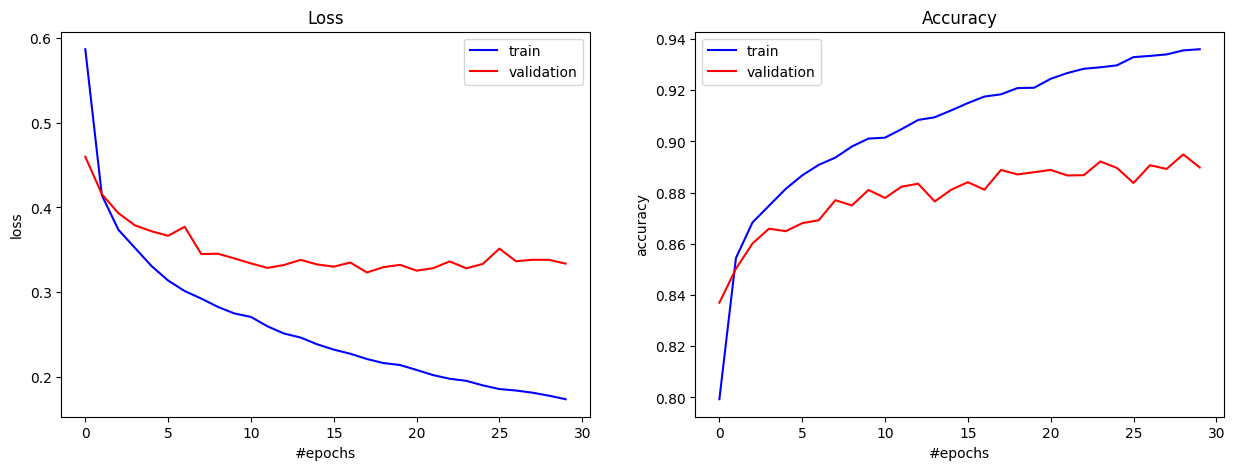

In [39]:
plot_train_process(train_loss_1, val_loss_1, train_accuracy_1, val_accuracy_1)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [21]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [22]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
              ReLU-3                 [-1, 1000]               0
            Linear-4                 [-1, 1000]       1,001,000
              ReLU-5                 [-1, 1000]               0
            Linear-6                 [-1, 1000]       1,001,000
              ReLU-7                 [-1, 1000]               0
            Linear-8                 [-1, 1000]       1,001,000
              ReLU-9                 [-1, 1000]               0
           Linear-10                 [-1, 1000]       1,001,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                  [-1, 500]         500,500
             ReLU-13                  [-1, 500]               0
           Linear-14                   

In [23]:
model_2 = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model_2.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epochs_2 = 50

In [24]:
train_loss_2, val_loss_2, train_accuracy_2, val_accuracy_2 = train_model(
    model_2, train_loader, test_loader, loss_func, opt, n_epochs_2)

Epoch 1/50, took 10.587 s; train loss: 0.7324, val loss: 0.4575; train acc: 0.7126, val acc: 0.8382
Epoch 2/50, took 10.074 s; train loss: 0.4059, val loss: 0.4149; train acc: 0.8550, val acc: 0.8540
Epoch 3/50, took 9.709 s; train loss: 0.3586, val loss: 0.3887; train acc: 0.8715, val acc: 0.8576
Epoch 4/50, took 10.583 s; train loss: 0.3355, val loss: 0.3875; train acc: 0.8809, val acc: 0.8647
Epoch 5/50, took 10.658 s; train loss: 0.3133, val loss: 0.3696; train acc: 0.8878, val acc: 0.8694
Epoch 6/50, took 9.242 s; train loss: 0.2981, val loss: 0.3692; train acc: 0.8916, val acc: 0.8723
Epoch 7/50, took 10.661 s; train loss: 0.2876, val loss: 0.3363; train acc: 0.8958, val acc: 0.8841
Epoch 8/50, took 10.594 s; train loss: 0.2779, val loss: 0.3510; train acc: 0.9004, val acc: 0.8795
Epoch 9/50, took 10.181 s; train loss: 0.2698, val loss: 0.3264; train acc: 0.9009, val acc: 0.8864
Epoch 10/50, took 9.633 s; train loss: 0.2547, val loss: 0.3617; train acc: 0.9063, val acc: 0.8762
Ep

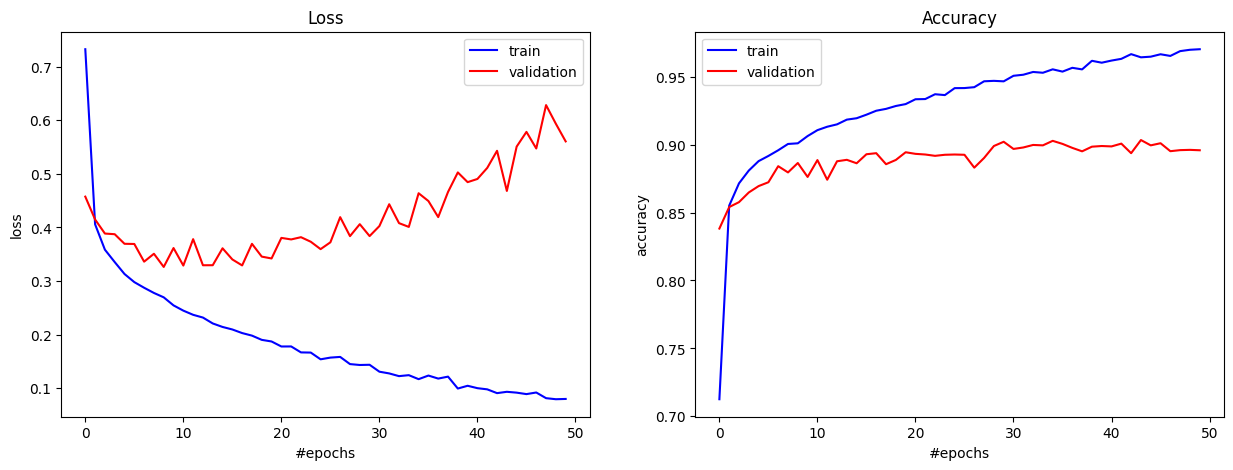

In [26]:
plot_train_process(train_loss_2, val_loss_2, train_accuracy_2, val_accuracy_2)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [27]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(500, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(64, 10),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [28]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
       BatchNorm1d-3                 [-1, 1000]           2,000
           Dropout-4                 [-1, 1000]               0
              ReLU-5                 [-1, 1000]               0
            Linear-6                 [-1, 1000]       1,001,000
       BatchNorm1d-7                 [-1, 1000]           2,000
           Dropout-8                 [-1, 1000]               0
              ReLU-9                 [-1, 1000]               0
           Linear-10                 [-1, 1000]       1,001,000
      BatchNorm1d-11                 [-1, 1000]           2,000
          Dropout-12                 [-1, 1000]               0
             ReLU-13                 [-1, 1000]               0
           Linear-14                 [-

In [31]:
model_3 = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model_3.parameters(), lr=1e-3, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epochs_3 = 50

In [32]:
train_loss_3, val_loss_3, train_accuracy_3, val_accuracy_3 = train_model(
    model_3, train_loader, test_loader, loss_func, opt, n_epochs_3)

Epoch 1/50, took 12.024 s; train loss: 0.8685, val loss: 0.5068; train acc: 0.7045, val acc: 0.8156
Epoch 2/50, took 11.625 s; train loss: 0.5740, val loss: 0.4443; train acc: 0.8170, val acc: 0.8451
Epoch 3/50, took 10.524 s; train loss: 0.5107, val loss: 0.4072; train acc: 0.8364, val acc: 0.8541
Epoch 4/50, took 11.620 s; train loss: 0.4843, val loss: 0.4046; train acc: 0.8424, val acc: 0.8539
Epoch 5/50, took 11.768 s; train loss: 0.4673, val loss: 0.3956; train acc: 0.8474, val acc: 0.8611
Epoch 6/50, took 11.779 s; train loss: 0.4538, val loss: 0.3665; train acc: 0.8512, val acc: 0.8708
Epoch 7/50, took 11.478 s; train loss: 0.4415, val loss: 0.3835; train acc: 0.8539, val acc: 0.8665
Epoch 8/50, took 10.464 s; train loss: 0.4393, val loss: 0.3769; train acc: 0.8552, val acc: 0.8688
Epoch 9/50, took 11.640 s; train loss: 0.4377, val loss: 0.3679; train acc: 0.8586, val acc: 0.8653
Epoch 10/50, took 12.383 s; train loss: 0.4273, val loss: 0.3727; train acc: 0.8581, val acc: 0.8666

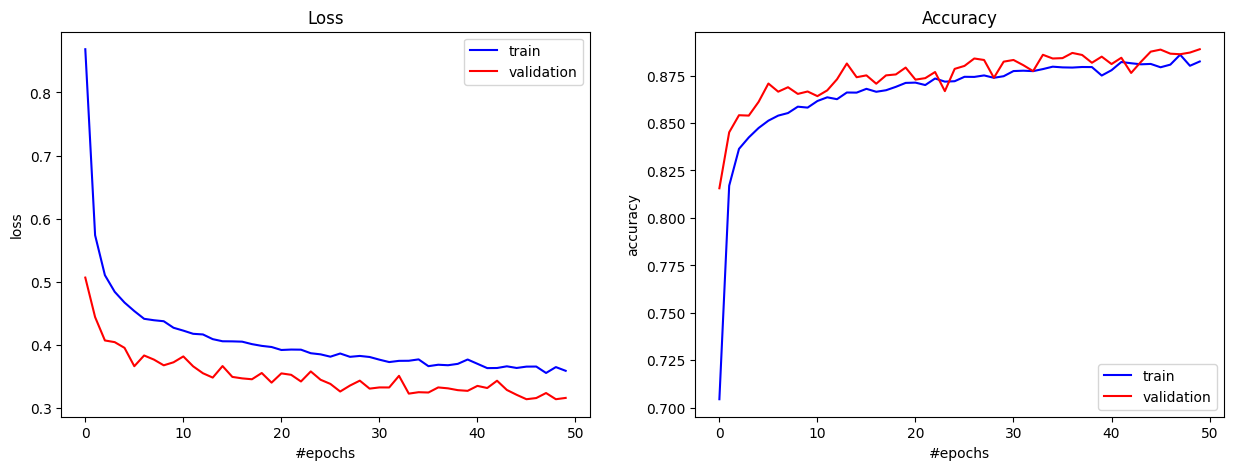

In [33]:
plot_train_process(train_loss_3, val_loss_3, train_accuracy_3, val_accuracy_3)

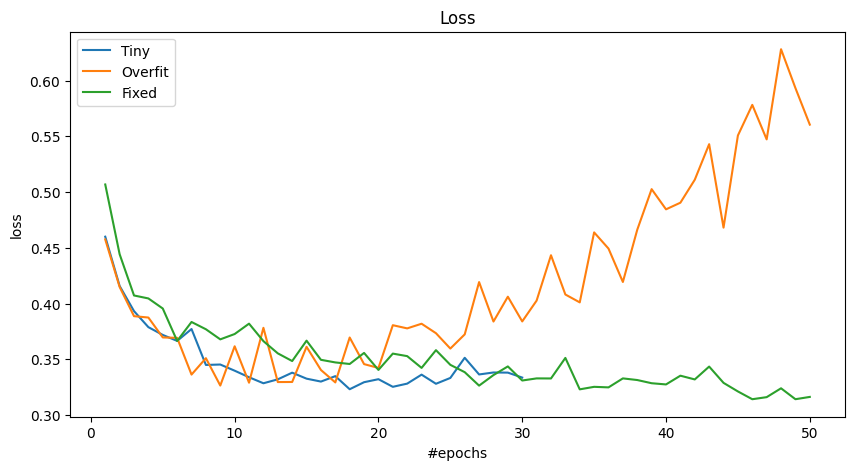

In [49]:
b, e = 0, None
x_1 = np.arange(1, n_epochs_1+1)
x_2 = np.arange(1, n_epochs_2+1)
x_3 = np.arange(1, n_epochs_3+1)

plt.figure(figsize=(10, 5))

plt.title('Loss')
plt.plot(x_1, val_loss_1, label='Tiny')
plt.plot(x_2, val_loss_2, label='Overfit')
plt.plot(x_3, val_loss_3, label='Fixed')
plt.legend()
plt.xlabel('#epochs')
plt.ylabel("loss")

plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

В начале для задания 1 я выбрал самую простую трех слойную сеть. Я пробовал подбирать количество нейроннов скрытого слоя, обеспечивающее необходимую точность классификации. Среди вариантов 64, 100, 128 подходящим оказался 128. По этогу такая сеть к концу 30 эпох достигла и смогла продержать точность выше 0.885. При этом переобучения не длостигается, поскольку лосс на протяжении всего процесса обучения не увеличивался, а accuracy не уменьшалась. Дальше увеличивать количестов параметров не стал, чтобы снизить риск переобучения.

Чтобы добиться от сети переобучения пришлось значительно ее увеличить. При этом пришлось также увеличить количество эпох до 50. В результатате сеть начала переобучаться, что в основном отразилось на лоссе по валидационной выборке: после 20-ой эпохи лосс начал значительно увеличиваться, т.е. сеть становилась все менее уверенной в своем выборе. При этом accuracy перестал увеличиваться и вышел на плато.

Для предотвращения переобучения после каждого линейного слоя были добавлены batch normalization и dropout. Это полностью решило проблему переобучения, т.к. теперь лосс монотонно убывает.